## Downloading NetCDF data for a given month

For downloading data from the Climate Data Store (CDS), we will use the `earthkit.data` package which includes a way to programmatically retreive the data from the CDS API. For more information about CDS data access, see our guide for [manually downloading CDS data](../getting-data/climate-data-store.ipynb). 

In [1]:
import earthkit.data

### Authenticate with your ECMWF user

Before we can download the dataset programmatically, we need to authenticate using our user credentials:

- Go to the [CDSAPI Setup page](https://cds.climate.copernicus.eu/how-to-api) and make sure to login.
- Once logged in, scroll down to the section "Setup the CDS API personal access token". 
  - This should show your login credentials, and look something like this:

        url: https://cds.climate.copernicus.eu/api
        key: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

- Copy those two lines to a file `.cdsapirc` in your user's $HOME directory.

### Accept the dataset license

ECMWF requires that you manually accept the user license for each dataset that you download. 

- Start by visiting the Download page of the dataset we are interested in: ["ERA5 post-processed daily statistics on single levels from 1940 to present"](https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=download). 
- Scroll down until you get to the "Terms of Use" section.
- Click the button to accept and login with your user if you haven't already. 

### Try an example request query

Earthkit provides a convenience method for retrieving data from CDS, `earthkit.data.from_source("cds", ...)`. To obtain the correct parameters to use for the data query, you can follow these steps:

- Manually go to the dataset [Download page](https://cds.climate.copernicus.eu/datasets/derived-era5-single-levels-daily-statistics?tab=download)
  - In our case, select 2m Temperature, select all days of a single month, and any subregion. 
- At the bottom of the page, click "Show API Request Code" in the "API Request" section.
- This should show something like this:

        import cdsapi

        dataset = "derived-era5-single-levels-daily-statistics"
        request = {
            "product_type": "reanalysis",
            "variable": ["2m_temperature"],
            "year": "2024",
            "month": ["12"],
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31"
            ],
            "daily_statistic": "daily_mean",
            "time_zone": "utc+00:00",
            "frequency": "1_hourly",
            "area": [-9.223115, 26.677001, -17.666611, 43.387206]
        }

        client = cdsapi.Client()
        client.retrieve(dataset, request).download()

Since `earthkit` uses `cdsapi` in the background, we can copy these parameter values directly to fill in the parameters required by `earthkit`. We also add two additional parameters to download as unzipped NetCDF format:

In [7]:
data = earthkit.data.from_source("cds",
    "derived-era5-single-levels-daily-statistics",
    {
        "product_type": "reanalysis",
        "variable": ["2m_temperature"],
        "year": "2024",
        "month": ["12"],
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ],
        "daily_statistic": "daily_mean",
        "time_zone": "utc+00:00",
        "frequency": "1_hourly",
        "area": [-9.223115, 26.677001, -17.666611, 43.387206],
        "data_format": "netcdf",
        "download_format": "unarchived",
    }
)

2025-10-07 14:25:45,229 INFO Request ID is 32899543-a274-46b3-8581-f79fcb545a30
2025-10-07 14:25:45,299 INFO status has been updated to accepted
2025-10-07 14:25:53,802 INFO status has been updated to running
2025-10-07 14:27:01,072 INFO status has been updated to successful


c28285aa1968f925f21176d0a10b8309.nc:   0%|          | 0.00/179k [00:00<?, ?B/s]

After some time we see that the download was successful. 

### Creating a generalized function for downloading data

In order to make this more useful, we generalize this in a function that modifies some of the download parameters based on input arguments. 

#### Year and month inputs

In our function we want the user to be able to input a `year` and `month`, and then update the necessary query parameters. To automatically select all individual days for a particular month, we can use the builtin Python function `calendar.monthrange(year, month)` to get the first and last day of each month. We also have to left-pad all numbers with zero. This function might look something like this:

In [ ]:
def download_temperature_for_month(year, month):
    import calendar
    # construct the query parameters
    params = {
        "product_type": "reanalysis",
        "variable": ["2m_temperature"],
        "year": str(year),
        "month": [str(month).zfill(2)],
        "daily_statistic": "daily_mean",
        "time_zone": "utc+00:00",
        "frequency": "1_hourly",
        "area": [-9.223115, 26.677001, -17.666611, 43.387206],
        "data_format": "netcdf",
        "download_format": "unarchived",
    }
    first_day,last_day = calendar.monthrange(year, month)
    params['day'] = [str(day).zfill(2) for day in range(first_day, last_day)]
    print(params)
    # download the data
    data = earthkit.data.from_source("cds",
        "derived-era5-single-levels-daily-statistics",
        params,
    )
    # return
    return data

#### Determining the area coordinates from organisation units

Notice that we didn't yet do anything with the `area` parameter. To make our function more generic we also want to set this `area` parameter based on the bounding box of our organisation unit geometries. We therefore add another function that calculates the bounding box from a `geopandas.GeoDataFrame` and allow a bounding box input to our download function. The updated code would look like this:

In [22]:
import geopandas as gpd

def get_bbox(org_units: gpd.GeoDataFrame):
    '''Returns bounding box of a geopandas GeoDataFrame in standard format: xmin,ymin,xmax,ymax.'''
    bbox = org_units.total_bounds
    return bbox

def download_temperature_for_month_and_bbox(year, month, bbox):
    import calendar
    # extract the coordinates from input bounding box
    xmin,ymin,xmax,ymax = bbox
    # construct the query parameters
    params = {
        "product_type": "reanalysis",
        "variable": ["2m_temperature"],
        "year": str(year),
        "month": [str(month).zfill(2)],
        "daily_statistic": "daily_mean",
        "time_zone": "utc+00:00",
        "frequency": "1_hourly",
        "area": [ymax, xmin, ymin, xmax], # notice the different ordering of coordinates
        "data_format": "netcdf",
        "download_format": "unarchived",
    }
    first_day,last_day = calendar.monthrange(year, month)
    params['day'] = [str(day).zfill(2) for day in range(first_day, last_day)]
    # download the data
    data = earthkit.data.from_source("cds",
        "derived-era5-single-levels-daily-statistics",
        params,
    )
    # return
    return data

#### Test case

Finally, let's try it out based on organisation units from Sierra Leone and February of 2012: 

In [ ]:
org_units = earthkit.data.from_source("file", '../data/sierra-leone-districts.geojson')
bbox = get_bbox(org_units.to_geopandas())
print('Bbox:', bbox)
data = download_temperature_for_month_and_bbox(2012, 2, bbox)

Bbox: [-13.3035   6.9176 -10.2658  10.0004]


When visualized, it looks like we correctly retrieved the relevant data:

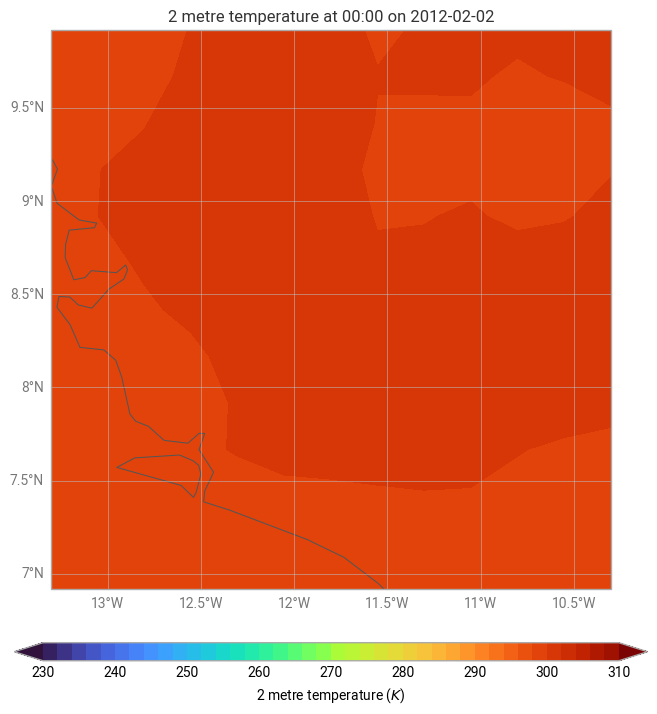

In [33]:
import earthkit.plots
array = data.to_xarray()
subset = array.sel(valid_time='2012-02-01', method='nearest')
earthkit.plots.quickplot(subset)

## Aggregating the data to organisation units

The next step is creating a generic function that aggregates the data downloaded from the previous step to a set of input organisation units:

In [44]:
def aggregate(data, org_units):
    from earthkit.transforms import aggregate
    # aggregate to org unit for each time period
    agg_data = aggregate.spatial.reduce(data, org_units, mask_dim="id")
    # convert to dataframe
    agg_df = agg_data.to_dataframe().reset_index()
    # return
    return agg_df

Let's try it for our previously downloaded test data:

In [45]:
agg = aggregate(data, org_units)
agg['t2m'] -= 273.15
agg

,valid_time,id,number,t2m
0,2012-02-02,O6uvpzGd5pu,0,27.335388
1,2012-02-02,fdc6uOvgoji,0,27.853302
2,2012-02-02,lc3eMKXaEfw,0,26.812439
3,2012-02-02,jUb8gELQApl,0,27.563202
4,2012-02-02,PMa2VCrupOd,0,27.259949
...,...,...,...,...
346,2012-02-28,jmIPBj66vD6,0,26.785797
347,2012-02-28,TEQlaapDQoK,0,27.028656
348,2012-02-28,bL4ooGhyHRQ,0,26.023712
349,2012-02-28,eIQbndfxQMb,0,27.649323


We see that the aggregated data contains temperature values for each organisation unit (`id`) and date in February 2012 that was included in the downloaded NetCDF data. 